In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [17]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
from sqlalchemy import inspect
inspector = inspect(engine)
lateststr = session.query(measurement.date).order_by(measurement.date.desc()).first()
lateststr

('2017-08-23',)

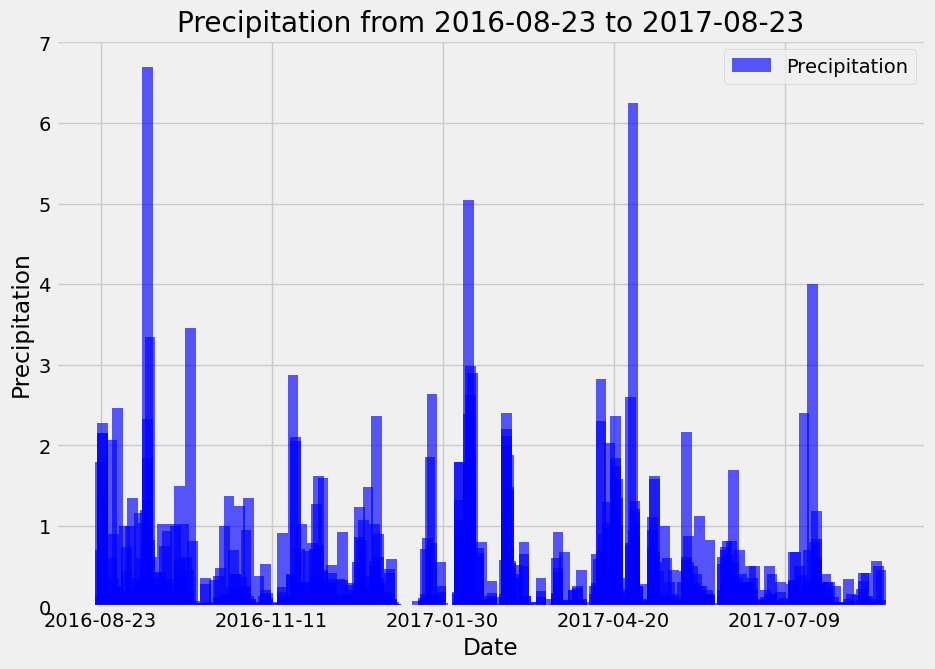

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)

# Perform a query to retrieve the data and precipitation scores
prec = [measurement.date,measurement.prcp]
queryresult = session.query(*prec).filter(measurement.date >= querydate).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])

# Sort the dataframe by date
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
xp = precipitation.index.tolist()
yp = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xp,yp,width = 5 ,color='b', alpha=.65, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,         
    labelbottom=True) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
prec = [measurement.station,func.count(measurement.id)]
activestations = session.query(*prec).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
prec = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
mostactivestationdata = session.query(*prec).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

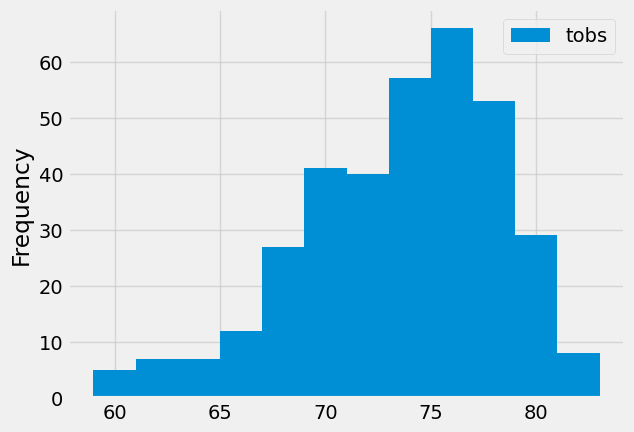

In [42]:
# Using the most active station id

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(measurement.tobs).\
    filter(measurement.station == activestations[0][0]).\
    filter(measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

prec = [station.station,station.name,station.latitude,station.longitude,station.elevation]
queryresult = session.query(*prec).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.legend()

# Close Session

In [16]:
# Close Session
session.close()